In [ ]:
import os, random, time
import numpy as np
import torch

CFG = {
    "seed": 42,
    "models": ["wide_resnet50_2", "resnext50_32x4d", "efficientnet_b0", "convnext_tiny"],
    "seeds": [42, 43, 44, 45],
    "batch_size": 128,
    "epochs": 120,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "mixup_alpha": 0.8,
    "label_smoothing": 0.1,
    "num_classes": 10,
    "img_size": 224,
    "save_dir": "/content/models",
    "results_dir": "/content/results"
}

os.makedirs(CFG["save_dir"], exist_ok=True)
os.makedirs(CFG["results_dir"], exist_ok=True)

assert torch.cuda.is_available()
device = torch.device("cuda")

def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG["seed"])
print("GPU:", torch.cuda.get_device_name(0))


GPU: Tesla T4


In [ ]:
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix


In [ ]:
def mixup_data(x, y, alpha):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    return lam * x + (1 - lam) * x[idx], y, y[idx], lam

def mixup_loss(loss_fn, preds, y1, y2, lam):
    return lam * loss_fn(preds, y1) + (1 - lam) * loss_fn(preds, y2)

def accuracy(preds, targets):
    return (preds.argmax(1) == targets).float().mean().item()


In [ ]:
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((CFG["img_size"], CFG["img_size"])),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
])

test_tf = transforms.Compose([
    transforms.Resize((CFG["img_size"], CFG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
])

full_train = CIFAR10("./data", train=True, download=True, transform=train_tf)
test_set = CIFAR10("./data", train=False, download=True, transform=test_tf)

idx = list(range(50000))
random.shuffle(idx)

train_idx = idx[:40000]
val_idx = idx[40000:45000]

train_set = Subset(CIFAR10("./data", train=True, transform=train_tf), train_idx)
val_set = Subset(CIFAR10("./data", train=True, transform=test_tf), val_idx)

train_loader = DataLoader(train_set, CFG["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, CFG["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, CFG["batch_size"], shuffle=False, num_workers=4)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Train: 40000 Val: 5000 Test: 10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def build_model(name):
    return timm.create_model(name, pretrained=True, num_classes=10).to(device)


In [ ]:
def train_model(model, seed, name):
    set_seed(seed)
    opt = optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, CFG["epochs"])
    loss_fn = nn.CrossEntropyLoss(label_smoothing=CFG["label_smoothing"])
    scaler = GradScaler()
    best = 0

    for ep in range(CFG["epochs"]):
        model.train()
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            x,y1,y2,lam = mixup_data(x,y,CFG["mixup_alpha"])
            opt.zero_grad()
            with autocast():
                out = model(x)
                loss = mixup_loss(loss_fn,out,y1,y2,lam)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        model.eval()
        accs=[]
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                accs.append(accuracy(model(x),y))
        val_acc = np.mean(accs)
        sch.step()

        if val_acc > best:
            best = val_acc
            torch.save(model.state_dict(), f"{CFG['save_dir']}/{name}.pth")

        print(name,"Epoch",ep+1,"ValAcc",round(val_acc,4))

    return best


In [ ]:
checkpoints = []

for name,seed in zip(CFG["models"],CFG["seeds"]):
    m = build_model(name)
    best = train_model(m, seed, name)
    checkpoints.append(name)
    print(name,"BEST VAL:",best)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

/tmp/ipython-input-3182101942.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3182101942.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


wide_resnet50_2 Epoch 1 ValAcc 0.9498
wide_resnet50_2 Epoch 2 ValAcc 0.9609
wide_resnet50_2 Epoch 3 ValAcc 0.9551
wide_resnet50_2 Epoch 4 ValAcc 0.9582


KeyboardInterrupt: 

In [ ]:
def train_model(model, seed, name):
    best_acc = 0.0

    for epoch in range(CFG["epochs"]):
        ...
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{CFG['save_dir']}/{name}.pth")
    return best_acc


In [ ]:
print("CHECKPOINTS:", checkpoints)


CHECKPOINTS: []


In [ ]:
import os
print(os.listdir(CFG["save_dir"]))


['wide_resnet50_2.pth']


In [ ]:
checkpoints = ["wide_resnet50_2"]


In [ ]:
def predict(model):
    model.eval()
    probs=[]
    with torch.no_grad():
        for x,_ in test_loader:
            x=x.to(device)
            probs.append(F.softmax(model(x),1).cpu())
    return torch.cat(probs)

all_probs=[]
for name in checkpoints:
    m=build_model(name)
    m.load_state_dict(torch.load(f"{CFG['save_dir']}/{name}.pth"))
    all_probs.append(predict(m))

ensemble_probs = torch.stack(all_probs).mean(0)
ensemble_preds = ensemble_probs.argmax(1)
labels = torch.tensor(test_set.targets)
test_acc = (ensemble_preds==labels).float().mean().item()

print("ENSEMBLE TEST ACC:",test_acc)


ENSEMBLE TEST ACC: 0.954200029373169


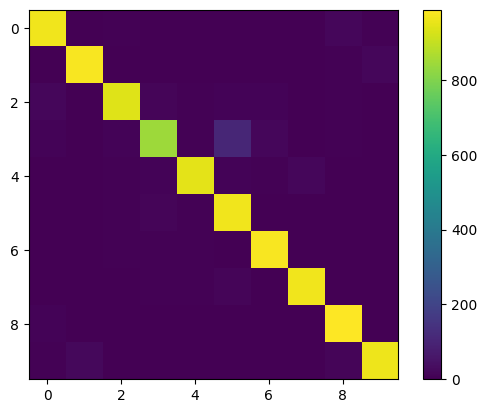

0 0.967
1 0.977
2 0.939
3 0.844
4 0.949
5 0.968
6 0.98
7 0.968
8 0.988
9 0.962


In [ ]:
cm = confusion_matrix(labels, ensemble_preds)
plt.imshow(cm); plt.colorbar(); plt.show()

for i in range(10):
    print(i, cm[i,i]/cm[i].sum())


In [ ]:
import os
import pandas as pd

os.makedirs(CFG["results_dir"], exist_ok=True)

pd.DataFrame({
    "index": range(len(labels)),
    "true": labels.cpu().numpy(),
    "pred": ensemble_preds.cpu().numpy(),
    "prob": ensemble_probs.max(1).values.cpu().numpy()
}).to_csv(f"{CFG['results_dir']}/predictions.csv", index=False)

with open("requirements.txt", "w") as f:
    f.write("\n".join([
        "torch",
        "torchvision",
        "timm",
        "numpy",
        "pandas",
        "scikit-learn",
        "matplotlib",
        "tqdm"
    ]))

print("Saved outputs")


Saved outputs
